In [1]:
import numpy as np
import os
from abc import abstractmethod
from scipy.stats import norm
import sklearn
import matplotlib.pyplot as plt

In [2]:
def load_data(folder):
    x_train = np.load(os.path.join(folder, 'x_train.npy'))
    y_train = np.load(os.path.join(folder, 'y_train.npy'))    
    x_test = np.load(os.path.join(folder, 'x_test.npy'))    
    y_test = np.load(os.path.join(folder, 'y_test.npy'))    
    return x_train, y_train, x_test, y_test

In [3]:
def assert_preds_correct(your_preds, sklearn_preds) -> bool:
    return np.abs(your_preds - sklearn_preds).sum() == 0

In [4]:
def assert_probs_correct(your_probs, sklearn_probs) -> bool:
    return np.abs(your_probs - sklearn_probs).mean() < 1e-3

In [5]:
# Не изменяйте код этого класса!
class NaiveBayes:
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.params = dict()
        
    # --- PREDICTION ---
        
    def predict(self, x, return_probs=False):
        """
        x - np.array размерности [N, dim], 
        где N - количество экземпляров данных, 
        dim -размерность одного экземпляра (количество признаков).
        
        Возвращает np.array размерности [N], содержащий номера классов для
        соответствующих экземпляров.
        """
        preds = []
        for sample in x:
            preds.append(
                self.predict_single(sample, return_probs=return_probs)
            )
        
        if return_probs:
            return np.array(preds, dtype='float32')
        
        return np.array(preds, dtype='int32')
    
    # Совет: вниманительно изучите файл подсказок к данной лабораторной
    # и сопоставьте код с описанной математикой байесовского классификатора.
    def predict_single(self, x, return_probs=False) -> int:
        """
        Делает предсказание для одного экземпляра данных.
        
        x - np.array размерности dim.
        
        Возвращает номер класса, которому принадлежит x.
        """
        assert len(x.shape) == 1, f'Expected a vector, but received a tensor of shape={x.shape}'
        marginal_prob = self.compute_marginal_probability(x)  # P(x) - безусловная вероятность появления x
        
        probs = []
        for c in range(self.n_classes):                 # c - номер класса
            prior = self.compute_prior(c)               # P(c) - априорная вероятность (вероятность появления класса)
            likelihood = self.compute_likelihood(x, c)  # P(x|c) - вероятность появления x в предположении, что он принаждлежит c
            
            # Используем теорему Байесса для просчёта условной вероятности P(c|x)
            # P(c|x) = P(c) * P(x|c) / P(x)
            prob = prior * likelihood / marginal_prob
            probs.append(prob)
            
        if return_probs:
            return probs
        
        return np.argmax(probs)
    
    # Вычисляет P(x) - безусловная вероятность появления x.
    @abstractmethod
    def compute_marginal_probability(self, x) -> float:
        pass
    
    # Вычисляет P(c) - априорная вероятность появления класса c.
    @abstractmethod
    def compute_prior(self, c) -> float:
        pass
    
    # Вычисляет P(x|c) - вероятность наблюдения экземпляра x в предположении, что он принаждлежит c.
    @abstractmethod
    def compute_likelihood(self, x, c) -> float:
        pass
    
    # --- FITTING ---
    
    def fit(self, x, y):
        self._estimate_prior(y)
        self._estimate_params(x, y)
    
    @abstractmethod
    def _estimate_prior(self, y):
        pass
    
    @abstractmethod
    def _estimate_params(self, x, y):
        pass

## 1. Наивный классификатор Байеса: гауссово распределение

Напишите недостающий код, создайте и обучите модель. 

Пункты оценки:
1. совпадение предсказанных классов с оными у модели sklearn. Для проверки совпадения используйте функцию `assert_preds_correct`.
2. совпадение значений предсказанных вероятностей принадлежности классами с оными у модели sklearn. Значения вероятностей считаются равными, если функция `assert_probs_correct` возвращает True.

In [6]:
x_train, y_train, x_test, y_test = load_data('gauss')

In [7]:
print(f"Тренировочная выборка имеет {x_train.shape[0]} экземпляров и {x_train.shape[1]} признаков\nЧисло разных классов -->{np.bincount(y_train)}")

Тренировочная выборка имеет 180 экземпляров и 2 признаков
Число разных классов -->[62 57 61]


In [8]:
print(f"Тестовая выборка имеет {x_test.shape[0]} экземпляров и {x_test.shape[1]} признаков\nЧисло разных классов -->{np.bincount(y_test)}")

Тестовая выборка имеет 60 экземпляров и 2 признаков
Число разных классов -->[18 23 19]


Text(0.5, 1.0, 'Тренировочная объекты')

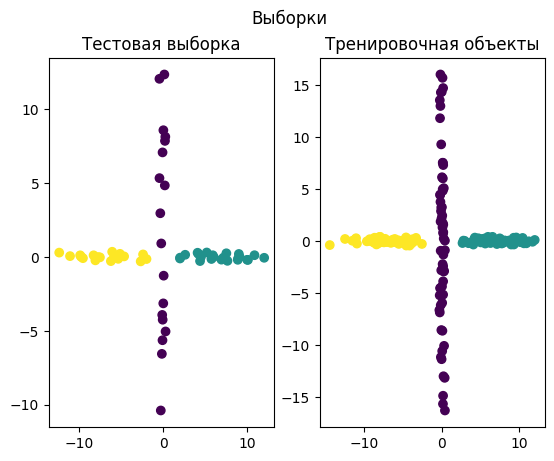

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Выборки')
ax1.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax1.set_title('Тестовая выборка')

ax2.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
ax2.set_title('Тренировочная объекты')

In [10]:
class NaiveGauss(NaiveBayes):
     # Вычисляет P(x) - безусловная вероятность появления x.
    def compute_marginal_probability(self, x) -> float:
        marginal_prob = 0.0
        for c in range(self.n_classes):
            marginal_prob += self.compute_prior(c) * self.compute_likelihood(x,c)
        return marginal_prob
    # Вычисляет P(c) - априорная вероятность появления класса c.
    def compute_prior(self, c) -> float:
        assert abs(sum(self.params['prior']) - 1.0) < 1e-3, \
            f"Sum of prior probabilities must be equal to 1, but is {sum(self.params['prior'])}"
        assert c < self.n_classes, f'Class index must be < {self.n_classes}, but received {c}.'
        # Напишите свой код здесь
        return self.params['prior'][c]

    def x_i_likelihood(self, x_i, c, feature_id) -> float:
        return norm.pdf(x_i,self.params['mean'][c,feature_id],self.params['disp'][c,feature_id])
        
    # Вычисляет P(x|c) - вероятность наблюдения экземпляра x в предположении, что он принаждлежит c.
    def compute_likelihood(self, x, c) -> float:
        assert c < self.n_classes, f'Class index must be < {self.n_classes}, but received {c}.'
        # Напишите свой код здесь
        likelihood = 1.0
        for feature_id in range(x_train.shape[1]):
            likelihood *= self.x_i_likelihood(x[feature_id],c,feature_id)
        return likelihood
        
    # --- FITTING ---
    
    def _estimate_prior(self, y):
        # Значения априорных вероятностей сохраните в `params` с ключом 'prior'
        # Напишите свой код здесь
        self.params['prior'] = np.bincount(y)/len(y)
        
    
    def _estimate_params(self, x, y):
        # Напишите свой код здесь
        self.params['mean'] = np.zeros((self.n_classes,x.shape[1]))
        self.params['disp'] = np.zeros((self.n_classes,x.shape[1]))
        for c in range(self.n_classes):
            class_C = x[c==y]
            for feature_id in range(x_train.shape[1]):
                self.params['mean'][c,feature_id] = np.mean(class_C[:,feature_id])
                self.params['disp'][c,feature_id] = np.std(class_C[:,feature_id])
    def pr(self):
        print(self.params)

In [1]:
# Создайте и обучите модель  
my_model = NaiveGauss(3)
my_model.fit(x_train,y_train)
y_fit = my_model.predict(x_test)

NameError: name 'NaiveGauss' is not defined

In [12]:
# Оцените качество модели
from sklearn.metrics import accuracy_score
accuracy_score_baseline_model = accuracy_score(y_test, y_fit_baseline)# считаем точность работы классификатора


In [13]:
print(
        f"Результаты NaiveGauss на тестовой выборке:\nЧисло экземпляров всех трех классов {np.bincount(y_fit)}")
print(
        f"\nЧисло реальных экземпляров тестовой выборке:\nЧисло экземпляров всех трех классов {np.bincount(y_test)}")
print(f"Точность NaiveGauss -> {accuracy_score_my_model}")

Результаты NaiveGauss на тестовой выборке:
Число экземпляров всех трех классов [18 23 19]

Число реальных экземпляров тестовой выборке:
Число экземпляров всех трех классов [18 23 19]
Точность NaiveGauss -> 1.0


Text(0.5, 1.0, 'Предсказанные объекты')

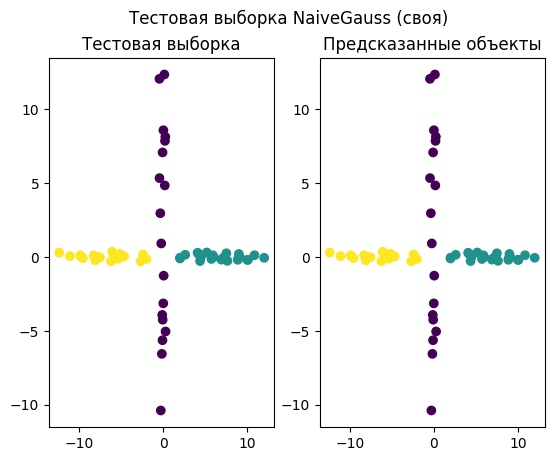

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Тестовая выборка NaiveGauss (своя)')
ax1.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax1.set_title('Тестовая выборка')

ax2.scatter(x_test[:, 0], x_test[:, 1], c=y_fit)
ax2.set_title('Предсказанные объекты')

In [15]:
# Сравните вашу модель с аналогом sklearn (GaussianNB)
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train, y_train)
y_fit_GaussianNB = clf.predict(x_test)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score_GaussianNB = accuracy_score(y_test, y_fit_GaussianNB) # считаем точность работы классификатора


In [20]:
print(
        f"Результаты GaussianNB на тестовой выборке:\nЧисло экземпляров всех трех классов {np.bincount(y_fit_GaussianNB)}")
print(
        f"\nЧисло реальных экземпляров тестовой выборке:\nЧисло экземпляров всех трех классов {np.bincount(y_test)}")
print(f"Точность GaussianNB -> {accuracy_score_GaussianNB}")

Результаты GaussianNB на тестовой выборке:
Число экземпляров всех трех классов [18 23 19]

Число реальных экземпляров тестовой выборке:
Число экземпляров всех трех классов [18 23 19]
Точность GaussianNB -> 1.0


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [22]:
report_NaiveGauss = classification_report(y_test, y_fit)# используем функцию отчета о классификаторе, которая подсчитает все метрики
confusion_LNaiveGauss = confusion_matrix(y_test, y_fit)# используем функцию, которая вернет матрицу ошибок
disp_NaiveGauss = ConfusionMatrixDisplay(confusion_LNaiveGauss, display_labels=[0, 1])# визуализируем  матрицу ошибок

In [23]:
report_GaussianNB = classification_report(y_test, y_fit)# используем функцию отчета о классификаторе, которая подсчитает все метрики
confusion_GaussianNB = confusion_matrix(y_test, y_fit)# используем функцию, которая вернет матрицу ошибок
disp_GaussianNB = ConfusionMatrixDisplay(confusion_GaussianNB, display_labels=[0, 1])# визуализируем  матрицу ошибок

In [24]:
import seaborn as sns

Модели предсказали всё одинаково
Их точности составили 1.0


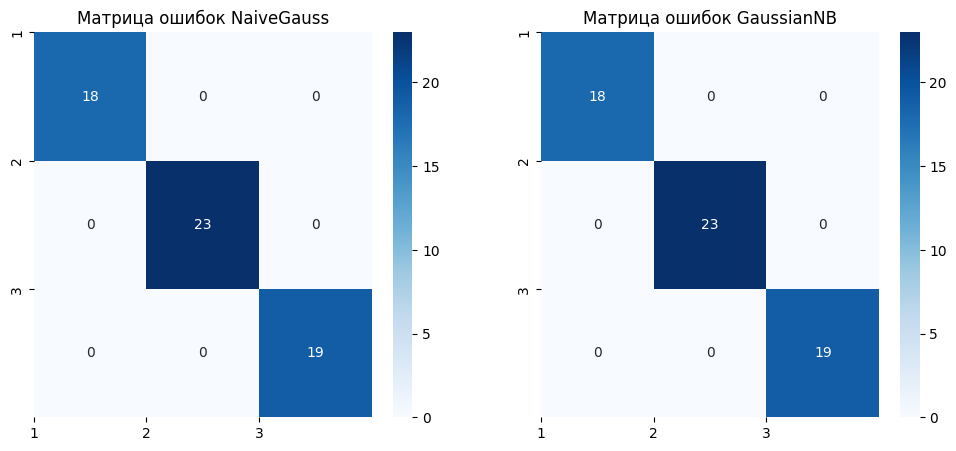

In [25]:
if(np.array_equal(y_fit_GaussianNB, y_fit)):
    print(f"Модели предсказали всё одинаково\nИх точности составили {accuracy_score_GaussianNB}")
else:
    print("Модели предскази по-разному")
    
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Создаем тепловую карту (heatmap) для первой матрицы ошибок
sns.heatmap(confusion_LNaiveGauss, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Матрица ошибок NaiveGauss')
# Создаем тепловую карту (heatmap) для второй матрицы ошибок
sns.heatmap(confusion_GaussianNB, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title('Матрица ошибок GaussianNB')
# Настраиваем метки и цветные шкалы
class_names = ['1', '2', '3']
for ax in axes:
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    


Text(0.5, 1.0, 'Предсказанные объекты')

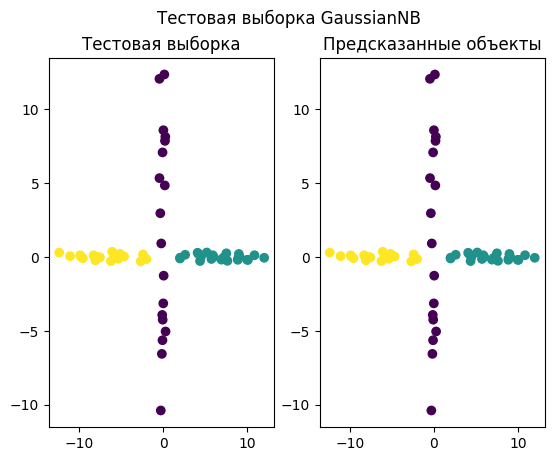

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Тестовая выборка GaussianNB')
ax1.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax1.set_title('Тестовая выборка')

ax2.scatter(x_test[:, 0], x_test[:, 1], c=y_fit_GaussianNB)
ax2.set_title('Предсказанные объекты')

Оба классификатора показали **100**% результаты!!!

## 2. Доп. задания (любое на выбор, опционально)

### 2.1  Упрощение наивного классификатора Байеса для гауссова распределения

Уберите из класса NaiveBayes 'лишние' вычисления и удалите код, что соответствует этим вычислениям. Под 'лишним' подразумеваются вещи, что не влияют на итоговое решение о принадлежности классу (значения вероятностей при этом могу стать некорректными, но в данном задании это допустимо).

Напишите в клетке ниже код упрощенного 'классификатора Гаусса' и убедитесь, что его ответы (не значения вероятностей) совпадают с ответами классификатора из задания 1.

Указание: работайте в предположении, что классы равновероятны.

In [21]:
# Напишите обновленный код модели здесь
# Не изменяйте код этого класса!
class NaiveBayes_2:
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.params = dict()

    def predict(self, x, return_probs=False):
        """
        x - np.array размерности [N, dim], 
        где N - количество экземпляров данных, 
        dim -размерность одного экземпляра (количество признаков).
        
        Возвращает np.array размерности [N], содержащий номера классов для
        соответствующих экземпляров.
        """
        preds = []
        for sample in x:
            preds.append(
                self.predict_single(sample, return_probs=return_probs)
            )
        
        if return_probs:
            return np.array(preds, dtype='float32')
        
        return np.array(preds, dtype='int32')
    
    # Совет: вниманительно изучите файл подсказок к данной лабораторной
    # и сопоставьте код с описанной математикой байесовского классификатора.
    def predict_single(self, x, return_probs=False) -> int:
        """
        Делает предсказание для одного экземпляра данных.
        
        x - np.array размерности dim.
        
        Возвращает номер класса, которому принадлежит x.
        """
        assert len(x.shape) == 1, f'Expected a vector, but received a tensor of shape={x.shape}'
        marginal_prob = self.compute_marginal_probability(x)  # P(x) - безусловная вероятность появления x
        
        probs = []
        for c in range(self.n_classes):                 # c - номер класса
            likelihood = self.compute_likelihood(x, c)  # P(x|c) - вероятность появления x в предположении, что он принаждлежит c
            # Используем теорему Байесса для просчёта условной вероятности P(c|x)
            prob = likelihood / marginal_prob
            probs.append(prob)
            
        if return_probs:
            return probs
        
        return np.argmax(probs)
        
        
    # Вычисляет P(x) - безусловная вероятность появления x.
    def compute_marginal_probability(self, x) -> float:
        marginal_prob = 0.0
        for c in range(self.n_classes):
            marginal_prob += self.compute_likelihood(x,c)
        return marginal_prob
    
    # Вычисляет P(x|c) - вероятность наблюдения экземпляра x в предположении, что он принаждлежит c.
    def x_i_likelihood(self, x_i, c, feature_id) -> float:
        return norm.pdf(x_i,self.params['mean'][c,feature_id],self.params['disp'][c,feature_id])
         
    def compute_likelihood(self, x, c) -> float:
        assert c < self.n_classes, f'Class index must be < {self.n_classes}, but received {c}.'
        # Напишите свой код здесь
        likelihood = 1.0
        for feature_id in range(x_train.shape[1]):
            likelihood *= self.x_i_likelihood(x[feature_id],c,feature_id)
        return likelihood
    
    def fit(self, x, y):
        self._estimate_params(x, y)
    
    def _estimate_params(self, x, y):
        self.params['mean'] = np.zeros((self.n_classes,x.shape[1]))
        self.params['disp'] = np.zeros((self.n_classes,x.shape[1]))
        for c in range(self.n_classes):
            class_C = x[c==y]
            for feature_id in range(x_train.shape[1]):
                self.params['mean'][c,feature_id] = np.mean(class_C[:,feature_id])
                self.params['disp'][c,feature_id] = np.std(class_C[:,feature_id])

In [22]:
# Создайте и обучите модель
my_model_2 = NaiveBayes_2(3)
my_model_2.fit(x_train,y_train)
y_fit_2 = my_model.predict(x_test)

In [23]:
# Оцените качество модели
report_NaiveBayes_2 = classification_report(y_test, y_fit_2)# используем функцию отчета о классификаторе, которая подсчитает все метрики
confusion_NaiveBayes_2 = confusion_matrix(y_test, y_fit_2)# используем функцию, которая вернет матрицу ошибок
disp_NaiveBayes_2 = ConfusionMatrixDisplay(confusion_LNaiveGauss, display_labels=[0, 1])# визуализируем  матрицу ошибок

In [24]:
print(f"Метрики NaiveBayes_2:\n{report_NaiveBayes_2}\n")

Метрики NaiveBayes_2:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        19

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60




Модели предсказали всё одинаково
Их точности составили 1.0


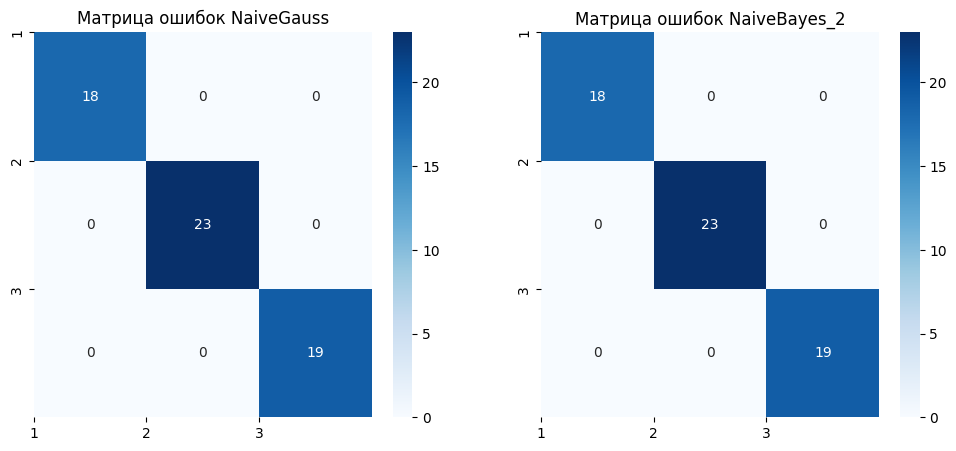

In [25]:
# Сравните вашу модель с моделью из задания 1
if(np.array_equal(y_fit_2, y_fit)):
    print(f"Модели предсказали всё одинаково\nИх точности составили {accuracy_score_GaussianNB}")
else:
    print("Модели предскази по-разному")
    
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Создаем тепловую карту (heatmap) для первой матрицы ошибок
sns.heatmap(confusion_LNaiveGauss, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Матрица ошибок NaiveGauss')
# Создаем тепловую карту (heatmap) для второй матрицы ошибок
sns.heatmap(confusion_NaiveBayes_2, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title('Матрица ошибок NaiveBayes_2')
# Настраиваем метки и цветные шкалы
class_names = ['1', '2', '3']
for ax in axes:
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    

Были полностью удалены вычисления P(c) (априорной вероятности появления класса c), так как оно одинакова для всех и при раскрытии скобок в знаменателе , то оно бы сократилось в числителе и знаменателе. Точность модели составила **100**%.

### 2.1  Наивный классификатор Байеса: мультиномиальное распределения

Напишите недостающий код, создайте и обучите модель.

Подсказка: в определении функции правдоподобия много факториалов. Для избежания численного переполнения посчитайте сначала логарифм функции правдоподобия (на бумаге), после примените экспоненту для получения значения вероятности.

Пункты оценки аналогичны оным из задания 1.

Сложность: математический гений.

In [28]:
x_train, y_train, x_test, y_test = load_data('multinomial')

In [29]:
print(f"Тренировочная выборка имеет {x_train.shape[0]} экземпляров и {x_train.shape[1]} признаков\nЧисло разных классов -->{np.bincount(y_train)}")

Тренировочная выборка имеет 24375 экземпляров и 1000 признаков
Число разных классов -->[12191 12184]


In [30]:
print(f"Тестовая выборка имеет {x_test.shape[0]} экземпляров и {x_test.shape[1]} признаков\nЧисло разных классов -->{np.bincount(y_test)}")

Тестовая выборка имеет 624 экземпляров и 1000 признаков
Число разных классов -->[309 315]


In [126]:
"""
При желании данный класс можно переписать с нуля. Изменения должны сопровождаться комментариями.
"""
class NaiveMultinomial(NaiveBayes):
    def __init__(self, n_classes):
        super().__init__(n_classes)
        self.list_word= dict()
        
    def compute_marginal_probability(self, x) -> float:
        # Для просчёта безусловной вероятности используйте 
        # методы compute_prior и compute_likelihood.
        # Напишите свой код здесь
        p = 0.0
        for c in range(self.n_classes):
            p += self.compute_prior(c) * self.compute_likelihood(x, c)
        return p
    
    def compute_prior(self, c) -> float:
        assert abs(sum(self.params['prior']) - 1.0) < 1e-3, \
            f"Sum of prior probabilities must be equal to 1, but is {sum(self.params['prior'])}"
        assert c < self.n_classes, f'Class index must be < {self.n_classes}, but received {c}.'
        # Напишите свой код здесь
        return self.params['prior'][c]
    
    def compute_likelihood(self, x, c) -> float:
        assert c < self.n_classes, f'Class index must be < {self.n_classes}, but received {c}.'
        # Напишите свой код здесь
        likelihood = 1.0
        count_words = len(self.list_word)
        for word in x:
            word_count = self.params['class_word_count'][c].get(word, 0)
            
            smoothed_prob = np.log((word_count + 1) / (self.params['class_doc_count'][c] + count_words))
            likelihood *= np.exp(smoothed_prob)
        print(likelihood)
        return likelihood
    
    # --- FITTING ---
    
    def _estimate_prior(self, y):
        # Значения априорных вероятностей сохраните в `params` с ключом 'prior'
        # Напишите свой код здесь
        self.params['prior'] = np.bincount(y)/len(y)
    
    def _estimate_params(self, x, y):
        # Напишите свой код здесь
        self.list_word = set(word for doc in x for word in doc) # создаем список уникальных значеия, встречающихся в x_train
        self.params['class_word_count'] = [Counter() for _ in range(self.n_classes)]
        self.params['class_doc_count'] = [x[y==c].shape[0] for c in range(self.n_classes)]
        for i in range(x.shape[0]):
            self.params['class_word_count'][y[i]] += Counter(x[i])
    
    def pr(self):
        print(self.params,'\n','\n', self.list_word)

In [127]:
# Создайте и обучите модель
my_model_mul = NaiveMultinomial(2)
my_model_mul.fit(x_train,y_train)

In [91]:
my_model_mul.pr()

{'prior': array([0.50014359, 0.49985641]), 'word_count': [Counter({0: 11530706, 1: 544445, 2: 82088, 3: 20252, 4: 7027, 5: 3014, 6: 1481, 7: 794, 8: 426, 9: 233, 10: 178, 11: 119, 12: 57, 13: 50, 14: 38, 15: 22, 16: 17, 18: 14, 17: 12, 20: 8, 19: 4, 22: 4, 27: 2, 21: 2, 24: 2, 23: 2, 31: 1, 26: 1, 25: 1}), Counter({0: 11536019, 1: 531303, 2: 81943, 3: 20737, 4: 7212, 5: 3172, 6: 1529, 7: 815, 8: 452, 9: 289, 10: 147, 11: 117, 12: 86, 13: 48, 14: 39, 15: 25, 17: 15, 16: 13, 18: 11, 19: 9, 20: 5, 21: 3, 22: 3, 24: 3, 23: 2, 25: 2, 26: 1})], 'doc_count': [12191, 12184]} 
 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31}


In [128]:
my_model_mul.fit(x_train,y_train)
y_fit = my_model_mul.predict(x_test)
# my_model_mul.compute_likelihood(x_test[0,:],0)

C:\Users\nikit\AppData\Local\Temp\ipykernel_13732\2895163846.py:34: RuntimeWarning: overflow encountered in scalar multiply
  likelihood *= np.exp(smoothed_prob)
C:\Users\nikit\AppData\Local\Temp\ipykernel_13732\1205318557.py:49: RuntimeWarning: invalid value encountered in scalar divide
  prob = prior * likelihood / marginal_prob


inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


In [125]:
print(y_fit)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
# Оцените качество модели

In [ ]:
# Сравните вашу модель с аналогом sklearn (MultinomialNB)